# Patient level Diagnosis prediction using Metapath-based HGCN


In [1]:
import numpy as np
from torch_geometric.utils.convert import from_networkx
from sklearn.model_selection import train_test_split
import networkx as nx 
import matplotlib.pyplot as plt

import extractingHG as exHG

In [2]:
# Extracting the information...

exHG.extracting_patient_visit_labels()

Patient (C_56)
Patient (C_103)
Patient (C_150)
Patient (C_222)
Patient (C_281)
Patient (C_291)
Patient (C_463)
Patient (C_471)
Patient (C_538)
Patient (C_636)
Patient (C_739)
Patient (C_781)
Patient (C_860)
Patient (C_863)
Patient (C_923)
Patient (C_1006)
Patient (C_1068)
Patient (C_1093)
Patient (C_1162)
Patient (C_1236)
Patient (C_1301)
Patient (C_1313)
Patient (C_1336)
Patient (C_1356)
Patient (C_1397)
Patient (C_1441)
Patient (C_1531)
Patient (C_1534)
Patient (C_1619)
Patient (C_1656)
Patient (C_1673)
Patient (C_1705)
Patient (C_1770)
Patient (C_1793)
Patient (C_1860)
Patient (C_1902)
Patient (C_1930)
Patient (C_1972)
Patient (C_1985)
Patient (C_1997)
Patient (C_2021)
Patient (C_2057)
Patient (C_2076)
Patient (C_2085)
Patient (C_2116)
Patient (C_2128)
Patient (C_2194)
Patient (C_2208)
Patient (C_2262)
Patient (C_2538)
Patient (C_2549)
Patient (C_2657)
Patient (C_2716)
Patient (C_2800)
Patient (C_2811)
Patient (C_2855)
Patient (C_2871)
Patient (C_2904)
Patient (C_3055)
Patient (C_32

In [3]:
# Reading everything...
Patients    = exHG.reading_pickle('Data/symmetricPath/patients.pickle')
Visits      = exHG.reading_pickle('Data/symmetricPath/visits.pickle')
Medications = exHG.reading_pickle('Data/symmetricPath/medication.pickle')
Diagnosis   = exHG.reading_pickle('Data/symmetricPath/diagnosis.pickle')
Procedures  = exHG.reading_pickle('Data/symmetricPath/procedures.pickle')

# Reading the metapath (pathsim-based) overall similarity matrix
data        = exHG.reading_pickle('Data/symmetricPath/data.pickle')

# Reading the labels
Patients_label = exHG.reading_pickle('Data/labels/patient_labels.pickle')
Visits_label   = exHG.reading_pickle('Data/labels/visit_labels.pickle')


# Patient level Prediction

In [4]:
# Setting the graph based on the similarity matrix
G = nx.Graph()

Nodes = Patients + Visits + Medications + Diagnosis  + Procedures
G.add_nodes_from(Nodes)

# assign the Patient label as Y...
for node in G.nodes:
    if node[0]=='C':
        G.nodes[node]['y'] = Patients_label[node]
    else:
        G.nodes[node]['y'] = np.zeros((len(Diagnosis)))

# assign the weight of the edges into the graph
for i, v in enumerate(Nodes):
    if v[0]!= 'D':
        for j, u in enumerate(Nodes):
            if data[i][j]>0 and u[0]!='D':
                G.add_edge(v, u, weight=data[i][j])

# X = np.random.randn(len(list(G.nodes())), 128)
X = np.eye(len(list(G.nodes())))

for i, node in enumerate(list(G.nodes())):
    G.nodes[node]['x'] = X[i]


In [5]:
# Creating the data structure
data = from_networkx(G)

c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\torch_geometric\utils\convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  data[key] = torch.tensor(value)


In [6]:
print(data)

newY = []
total = 0

# extracting the visits nodes and their indexes for the learning process.
for i,v in enumerate(Nodes):
    if v[0]=='C':
        newY.append([i,data.y[i]])
        total+=1



Data(x=[2821, 2821], edge_index=[2, 2418040], y=[2821, 425], weight=[2418040])


## Creating new masks out of patient nodes only

In [7]:
y_train, y_left = train_test_split(newY    , train_size=0.7, random_state=42)
y_val,   y_test = train_test_split(y_left  , test_size=2/3, random_state=42)

# Create masks for train, validation, and test sets
train_mask = np.zeros(len(data.y), dtype=bool)
val_mask = np.zeros(len(data.y), dtype=bool)
test_mask = np.zeros(len(data.y), dtype=bool)

for i,v in y_train:
    train_mask[i] = True

for i,v in y_val:
    val_mask[i] = True

for i, v in y_test:
    test_mask[i] = True

print(train_mask.shape)
print(val_mask.shape)
print(test_mask.shape)

print('Train = ', sum([1 if v else 0 for v in train_mask])/total)
print('Val = ', sum([1 if v else 0 for v in val_mask])/total)
print('Test = ', sum([1 if v else 0 for v in test_mask])/total)

(2821,)
(2821,)
(2821,)
Train =  0.6993987975951904
Val =  0.10020040080160321
Test =  0.20040080160320642


In [8]:
data.train_mask = train_mask
data.test_mask  = test_mask
data.val_mask   = val_mask

Epoch: 010, Train Loss: 0.644, Val Acc: 0.000


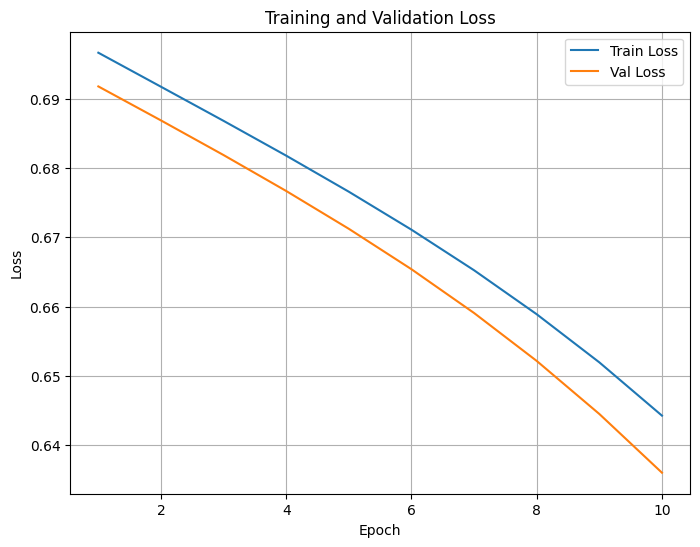

In [9]:
import GNN_multilabel as GNNM
import torch
import torch.nn.functional as F

data.x = data.x.float()
data.y = data.y.float()
num_classes = len(Diagnosis)

# Check if a GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data = data.to(device)
gcn = GNNM.GCN_MLC(data.num_node_features, num_classes).to(device)

optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()
# criterion = F.binary_cross_entropy_with_logits
criterion = torch.nn.BCEWithLogitsLoss()
gcn, df = GNNM.train_node_classifier(gcn, data, optimizer_gcn, criterion, n_epochs=10)

GNNM.plt_performance(df)

In [10]:
# ----------------------------------------------------------------------------
pred = gcn(data) #.argmax(dim=1)
pred    = pred  [data.test_mask].detach().cpu().numpy()
correct = data.y[data.test_mask].detach().cpu().numpy()

# print(pred.shape)
# print(correct.shape)

correct_binary = (correct > 0).astype(int)
pred_binary = (pred > 0).astype(int)

# GNNM.create_confusion_matrix(pred, correct)
GNNM.create_multilabel_confusion_matrix(pred_binary, correct_binary)

# test_acc, _ = GNNM.eval_node_classifier(gcn, data, data.test_mask)
# print(f'Test Acc: {test_acc:.3f}\n')

c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        70
           1       0.00      0.00      0.00       200
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00        41
           4       0.00      0.00      0.00        29
           5       0.00      0.00      0.00        15
           6       0.00      0.00      0.00        59
           7       0.00      0.00      0.00        81
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00        38
          10       0.00      0.00      0.00        32
          11       0.01      1.00      0.03         3
          12       0.02      1.00      0.04         4
          13       0.00      0.00      0.00        70
          14       0.00      0.00      0.00        12
          15       0.00      0.00      0.00        35
          16       0.00      0.00      0.00         9
          17       0.03    

c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Macro-Averaged Metrics:
Macro-Averaged F1 score = 0.007033671294179938
Macro-Averaged Precision score = 0.003811764705882353
Macro-Averaged AUC Precision score = 0.02442352941176471

Micro-Averaged Metrics:
Micro-Averaged F1 score = 0.02736948808920426
Micro-Averaged Precision score = 0.015
Micro-Averaged AUC Precision score = 0.022952805168310098



c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\almusawiaf\Anaconda3\envs\venvGNN\lib\site-packages\sklearn\metrics\_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


In [14]:
from sklearn.metrics import f1_score
print('F1- score : ', sum([f1_score(correct_binary[i], pred_binary[i], average='macro', zero_division=0) for i in range(len(correct_binary))])/len(correct_binary))

F1- score :  0.4345531978463446
